In [17]:
from sklearn.feature_selection import RFE, RFECV
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
import datetime
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)

In [18]:
# The training data.
train = pd.read_csv('../data/Train.csv')
test = pd.read_csv('../data/Test.csv')
ss = pd.read_csv('../data/SampleSubmission.csv')
train.shape, test.shape


# // The training data has many features so that could lead to a curse of dimensionality 
    # // dimentionality reduction - PCA and other methods
    # // feature selection for importance features ()

((83148, 29), (25584, 28))

In [3]:
# // only the target is not present in the testing set
    # // there is no column mismatch

for column in train.columns:
    if column not in test.columns:
        print(column)

burn_area


In [4]:
# // Investigate missing values
    # // There are no missing values

train.isnull().any().any(), test.isnull().any().any(), ss.isnull().any().any()

(False, False, False)

The skew value for the label is:  7.675599412401078
6.643186378864086
2.2837509973123558
3.200003493842135
1.2592819360219192


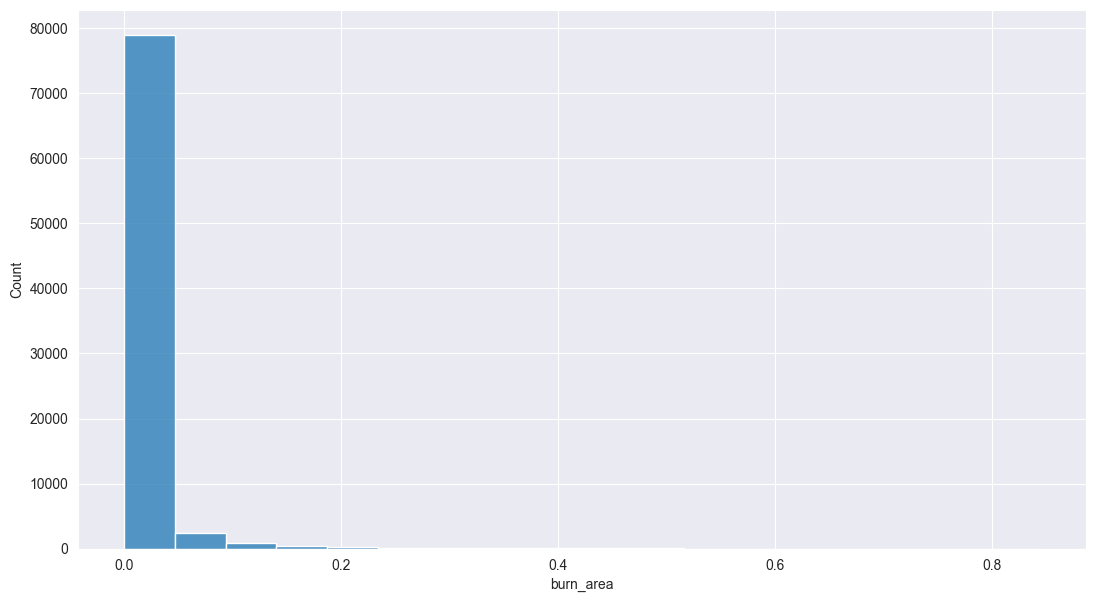

In [5]:
# // The target is highly skewed
    # // we need to transform it

print(f'The skew value for the label is:  {train.burn_area.skew()}')

# // Investigate some transformation techniques

print(np.log1p(train.burn_area).skew())
print(np.cbrt(train.burn_area).skew())
print(np.sqrt(train.burn_area).skew())
print((train.burn_area ** float(1/1024)).skew()) # This is the optimal one

sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.burn_area)
plt.show()

<Axes: >

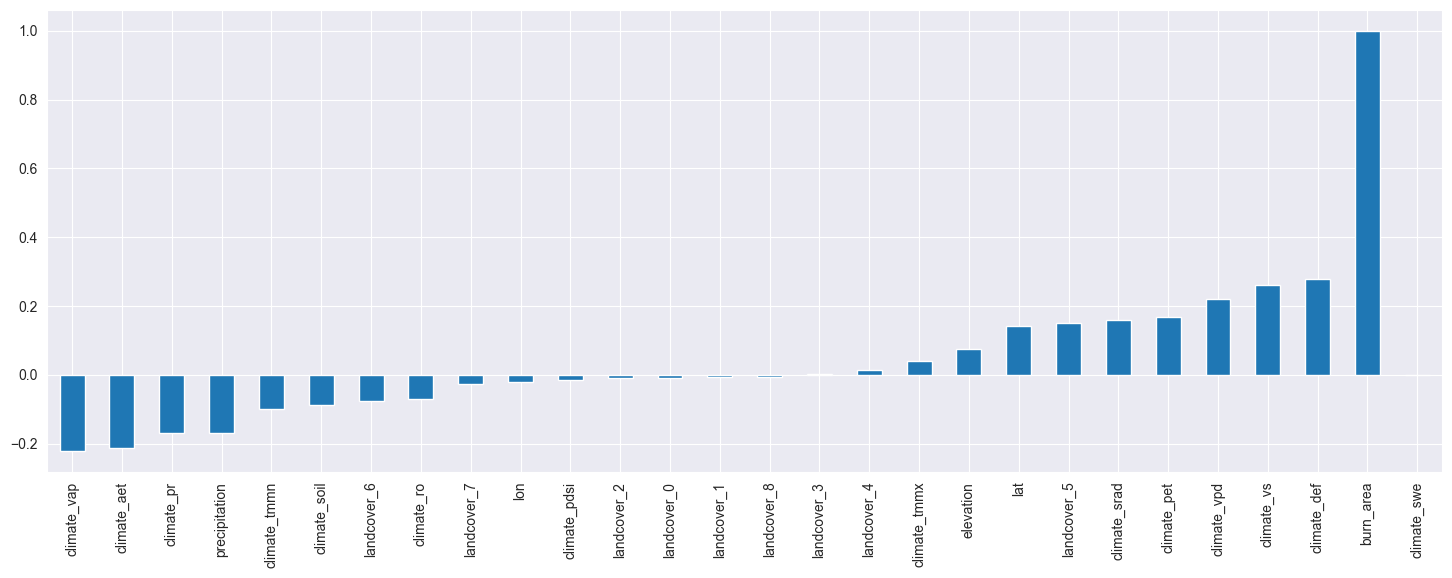

In [6]:
# Look at correlation with target
train.select_dtypes(include=['number']).corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

##  Adding date features

In [28]:
# //  Date variables

# train['burn_area'] = train.burn_area ** float(1/1024)
train['area'] = train['ID'].apply(lambda x: x.split('_')[0])
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
train['burn_area'] = pd.to_numeric(train['burn_area'], errors='coerce')

train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['day'] = train.date.dt.weekday
train['quarter'] = train.date.dt.quarter
train['dayofmonth'] = train.date.dt.day
train['dayofyear'] = train.date.dt.dayofyear
train['weekofyear'] = train.date.dt.isocalendar().week
train.set_index('date', inplace=True)

# // feature engineering features


train['interaction_vpd_landcover1'] = train['climate_vpd'] * train['landcover_1']
train['interaction_tmmx_vs'] = train['climate_tmmx'] * train['climate_vs']
train['lag_climate_pr'] = train.groupby('area')['climate_pr'].shift(1)
train['lag_climate_vpd'] = train.groupby('area')['climate_vpd'].shift(1)
spatial_features = train[['lat', 'lon', 'elevation']].dropna()
kmeans = KMeans(n_clusters=5, random_state=42).fit(spatial_features)
train['spatial_cluster'] = kmeans.predict(train[['lat', 'lon', 'elevation']])
train['burn_risk_index'] = (train['climate_vpd'] + train['climate_pdsi'] + train['climate_tmmx'] - train['climate_pr'])


# // Add lag featues to make it time series



In [26]:
'index' in train.columns

False

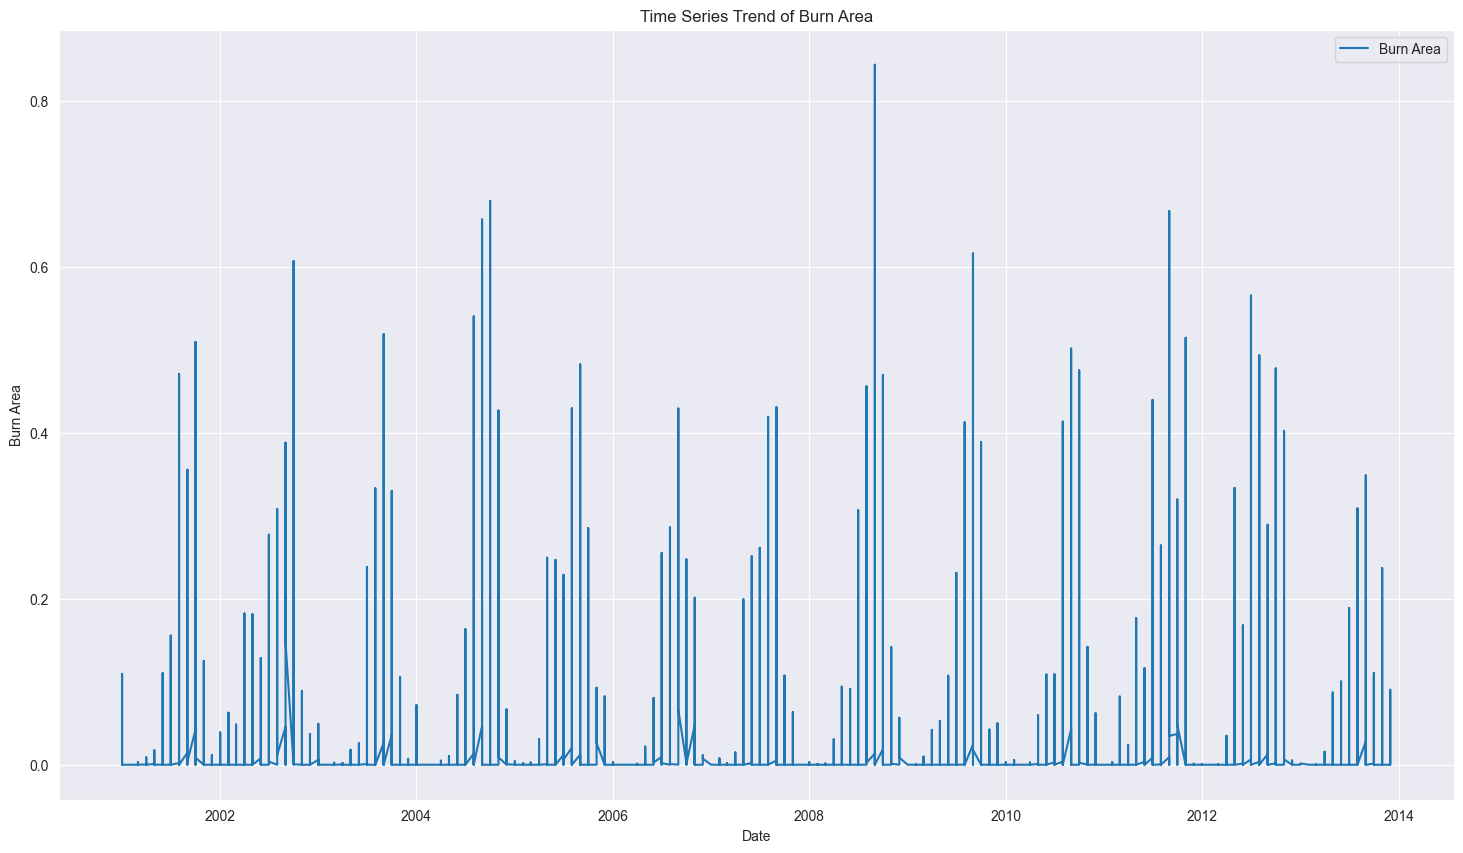

In [35]:
import pandas as pd
import matplotlib.pyplot as plt



# Plot the time series trend
plt.figure(figsize=(18, 10))
plt.plot(train.index, train['burn_area'], label='Burn Area')
plt.xlabel('Date')
plt.ylabel('Burn Area')
plt.title('Time Series Trend of Burn Area')
plt.legend()
plt.show()


## Utility Functions

In [8]:
# // Scaling

def scaler(X_train, X_test, minmax: bool=False):
    stdscaler = StandardScaler()
    X_train = stdscaler.fit_transform(X_train)
    X_test = stdscaler.transform(X_test)

    if minmax:
        minmaxscaler = MinMaxScaler(feature_range=(0,1))
        X_train = minmaxscaler.fit_transform(X_train)
        X_test = minmaxscaler.transform(X_test)
    return X_train, X_test


# // feature selection

def feature_selection(X_train, X_test, y_train, index: int=train.shape[1]) -> tuple:
    sel = RFE(
        estimator=RandomForestRegressor(
            n_estimators=100, random_state=42, n_jobs=-1
        ),
        n_features_to_select=index
    )
    sel.fit(X_train, y_train)
    X_train_rfe = sel.transform(X_train) 
    X_test_rfe = sel.transform(X_test)
    return X_train_rfe, X_test_rfe


# // Discretization

def binning(data: pd.DataFrame) -> pd.DataFrame:
    def optimal_k(data: pd.DataFrame, column: str, max_k: int=10):
        silhouette_scores = []
        X = data[column].values.reshape(-1, 1)
        for k in range(2, max_k+1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X)
            score = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(score)
            optimal_k = range(2, max_k+1)[silhouette_scores.index(max(silhouette_scores))]
        return optimal_k

    numerics = []
    for i in data.columns:
        if data[i].dtype == 'float':
            numerics.append(i)

    for column in numerics:
        if column != 'burn_area':
            k = optimal_k(data, column)
            reshaped_data = data[column].values.reshape(-1, 1)
            kmeans = KMeans(n_clusters=k, random_state=42)
            data[column] = kmeans.fit_predict(reshaped_data)
    return data


# // Handling outliers
    # // find other methods as well


def capping(data: pd.DataFrame, numerics=[]) -> pd.DataFrame:
    for col in numerics:
        if col != 'burn_area':
            q1 = data[col].quantile(0.25)
            q2 = data[col].quantile(0.75)
            iqr = q2 - q1
            max_limit = q2 + (1.5 * iqr)
            min_limit = q1 - (1.5 * iqr)
            data[col]  = pd.DataFrame(
                np.where(data[col] > max_limit, max_limit,
                (np.where(data[col] < min_limit, min_limit, data[col]))), columns=[col]
            )
    return data


# // Get the best model

def best_model(errors):
    scores = []
    for model in errors:
        scores.append(model['score'])
    for model in errors:
        if model['score'] == min(scores):
            return model['model']

# // Gaussian distribution for features

def transform(data):
    for column in data.columns:
        if data[column].dtype == 'float' or data[column].dtype == 'int64':
            if column != 'burn_area':
                if data[column].skew() > 2:
                    data[column] = data[column] ** float(1/1024)
    return data


## Machine Learning

In [9]:
# // data splicing


in_cols = []
target_col = 'burn_area'
for column in train.columns:
       if column != target_col:
              in_cols.append(column)

in_cols.remove('date')
in_cols.remove('ID')

train_all = train.copy().dropna()
train = train_all.loc[train_all.date < '2012-01-01']
valid = train_all.loc[train_all.date >= '2012-01-01']


X_train, y_train = train[in_cols], train[target_col]
X_valid, y_valid = valid[in_cols], valid[target_col]

In [10]:
# // Crucial Variables

transform_data=False
cap_data=False
bin_data=False
select_data=False
scale_data=False
reduce_dimension=False
n=2
index=10
minmax=False


# // apply utility
    # // capping outliers
    # // discretization
    # // feature selection
    # // Normalization
    # // PCA


if transform_data:
    train = transform(data=train)

if cap_data:
    train = capping(train)

if bin_data:
    train_binned = binning(train)

if select_data:
    X_train, X_valid = feature_selection(X_train, X_valid, y_train, index=index)

if scale_data:
    X_train, X_valid = scaler(X_train=X_train, X_test=X_valid, minmax=minmax)

if reduce_dimension:
    pca = PCA(n_components=n, random_state=42)
    pca = pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_valid = pca.transform(X_valid)

In [11]:

# // Train a couple of models


errors = []


# random_F = RandomForestRegressor(
#     random_state=42,
#     criterion='squared_error',
#     bootstrap=True,
#     max_features='sqrt',
#     warm_start=True
# )
# random_F.fit(X_train, y_train)
# preds = random_F.predict(X_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# errors.append({"model": "RandomForest", 'score': rmse})
# print("The RandomForest error is {}".format(rmse))


# gbr = GradientBoostingRegressor(
#     random_state=42,
#     criterion='squared_error',
#     loss='squared_error',
#     alpha=.1,
#     warm_start=True
# )
# gbr.fit(X_train, y_train)
# preds = gbr.predict(X_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# errors.append({"model": "GradientBoosting", 'score': rmse})
# print("The GradientBoostingRegressor error is {}".format(rmse))


# ada = AdaBoostRegressor(
#     random_state=42,
#     estimator=gbr,
#     learning_rate=1e-4,
#     loss='square',
#     n_estimators=100
# )
# ada.fit(X_train, y_train)
# preds = ada.predict(X_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# errors.append({"model": "AdaBoost", 'score': rmse})
# print("The AdaBoost with Gradient Boosting error is {}".format(rmse))


# ada_rf = AdaBoostRegressor(
#     random_state=42,
#     estimator=random_F,
#     learning_rate=1e-4,
#     loss='square',
#     n_estimators=100
# )
# ada_rf.fit(X_train, y_train)
# preds = ada_rf.predict(X_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# errors.append({"model": "AdaBoostForest", 'score': rmse})
# print("The AdaBoost with RandomForest error is {}".format(rmse))



# ada_DT = AdaBoostRegressor(
#     random_state=42,
#     estimator=DecisionTreeRegressor(
#         criterion="squared_error",
#         random_state=42,
#         max_features='sqrt',
#         max_depth=10
#     ),
#     learning_rate=1e-4,
#     loss='square',
#     n_estimators=100,
# )
# ada_DT.fit(X_train, y_train)
# preds = ada_DT.predict(X_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# errors.append({"model": "AdaBoostDT", 'score': rmse})
# print("The AdaBoost with DecisionTreeRegressor error is {}".format(rmse))


# ada_ada = AdaBoostRegressor(
#     random_state=42,
#     estimator=ada_DT,
#     learning_rate=1e-4,
#     loss='square',
#     n_estimators=100
# )
# ada_ada.fit(X_train, y_train)
# preds = ada_ada.predict(X_valid)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# errors.append({"model": "AdaBoostADA", 'score': rmse})
# print("The AdaBoost with AdaBoost error is {}".format(rmse))

In [12]:
reg = AdaBoostRegressor(
    random_state=42,
    estimator=DecisionTreeRegressor(
        criterion="squared_error",
        random_state=42,
        max_features='sqrt',
        max_depth=50  # Regularization by limiting the depth of the tree
    ),
    learning_rate=1e-4,
    loss='square',
    n_estimators=100
)


reg.fit(X_train, y_train)
preds = reg.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
errors.append({"model": "AdaBoostDTCV", 'score': rmse})
print("The AdaBoost with DecisionTreeRegressor error is {}".format(rmse))


The AdaBoost with DecisionTreeRegressor error is 0.01522704387193209


In [13]:
# reg = AdaBoostRegressor(
#     random_state=42,
#     estimator=DecisionTreeRegressor(
#         criterion="squared_error",
#         random_state=42,
#         max_features='sqrt',
#         max_depth=50  # Regularization by limiting the depth of the tree
#     ),
#     learning_rate=1e-4,
#     loss='square',
#     n_estimators=100
# )

# scores = []
# X = train[in_cols]
# y = train[target_col]
# for train_index, test_index in KFold(n_splits=3).split(X=X, y=y):
#     X_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
#     X_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]

#     reg.fit(X_train_fold, y_train_fold)
#     preds = reg.predict(X_test_fold)
#     scores.append(np.sqrt(mean_squared_error(y_test_fold, preds)))

# print(scores)
# rmse = np.mean(scores)
# print("mean: {}".format(rmse))
# errors.append({"model": "AdaBoostDTCV", 'score': rmse})

# Submission

In [14]:
# // get best model


best = best_model(errors=errors)
if best == 'AdaBoostDTCV':
    model = reg
# if best == "RandomForest":
#     model = random_F
# elif best == 'AdaBoost':
#     model = ada
# elif best == best_model_name:
#     model = tuned_ml_best_model
# elif best == 'GradientBoosting':
#     model = gbr
# elif best == 'AdaBoostForest':
#     model = ada_rf
# elif best == 'AdaBoostDT':
#     model = ada_DT
# elif best == 'AdaBoostADA':
#     model = ada_ada
# elif best == 'ANN':
#     model = network
# elif best == 'Tuned ANN':
#     model = tuned_model
# elif best == 'AdaBoostDTCV':
#     model = reg

In [15]:
# // Working with the testing data

test['area'] = test['ID'].apply(lambda x: x.split('_')[0])
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))
test.set_index('date', inplace=True)
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['day'] = test.date.dt.weekday
test['quarter'] = test.date.dt.quarter
test['dayofmonth'] = test.date.dt.day
test['dayofyear'] = test.date.dt.dayofyear
test['weekofyear'] = test.date.dt.isocalendar().week


test['interaction_vpd_landcover1'] = test['climate_vpd'] * test['landcover_1']
test['interaction_tmmx_vs'] = test['climate_tmmx'] * test['climate_vs']
test['lag_climate_pr'] = test.groupby('area')['climate_pr'].shift(1)
test['lag_climate_vpd'] = test.groupby('area')['climate_vpd'].shift(1)
test['spatial_cluster'] = kmeans.predict(test[['lat', 'lon', 'elevation']])
test['burn_risk_index'] = (test['climate_vpd'] + test['climate_pdsi'] + test['climate_tmmx'] - test['climate_pr'])

test = test.drop(['date'], axis=1)
test = test.drop(['ID'], axis=1)
test.fillna(0, inplace=True)


if cap_data:
    test = capping(test)
if transform_data:
    test = transform(data=test)
if bin_data:
    test_binned = binning(test)
if reduce_dimension:
    test = pca.transform(test[in_cols]) 
    preds = model.predict(test)
else:
    preds = model.predict(test)
    

# // submission file

ss['burn_area'] = preds
ss['burn_area'] = ss['burn_area'].clip(0, 1)
today = datetime.date.today()
value = '05'
ss.to_csv(f'../submissions/{today}_submit_{value}.csv', index=False)